# Introduction

In this lesson we'll discuss a fundamental method for avoid overfitting that is commonly referred to a the _train/test split_. 

The idea is very similar to something called "cross-validation" (indeed it is a type of cross-validation) in that we split the dataset into two subsets:
* a subset to train our model on, and
* a subset to test our model's predictions on

This serves two useful purposes:
* We prevent overfitting by not using all the data, and
* We have some remaining data to evaluate our model.

While it may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed 80% of data from California and 20% elsewhere and is sorted by state. If we split our data into 80% training data and 20% testing data we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them. holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Demo
Let's explore test-training split with some sample datasets.

In [1]:
% matplotlib inline

from matplotlib import pyplot as plt

# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

# Load the Boston Housing dataset
boston = datasets.load_boston()
boston.keys()

df = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

# Take a look at the data again
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Let's do just a little bit of EDA before we jump into the modelling

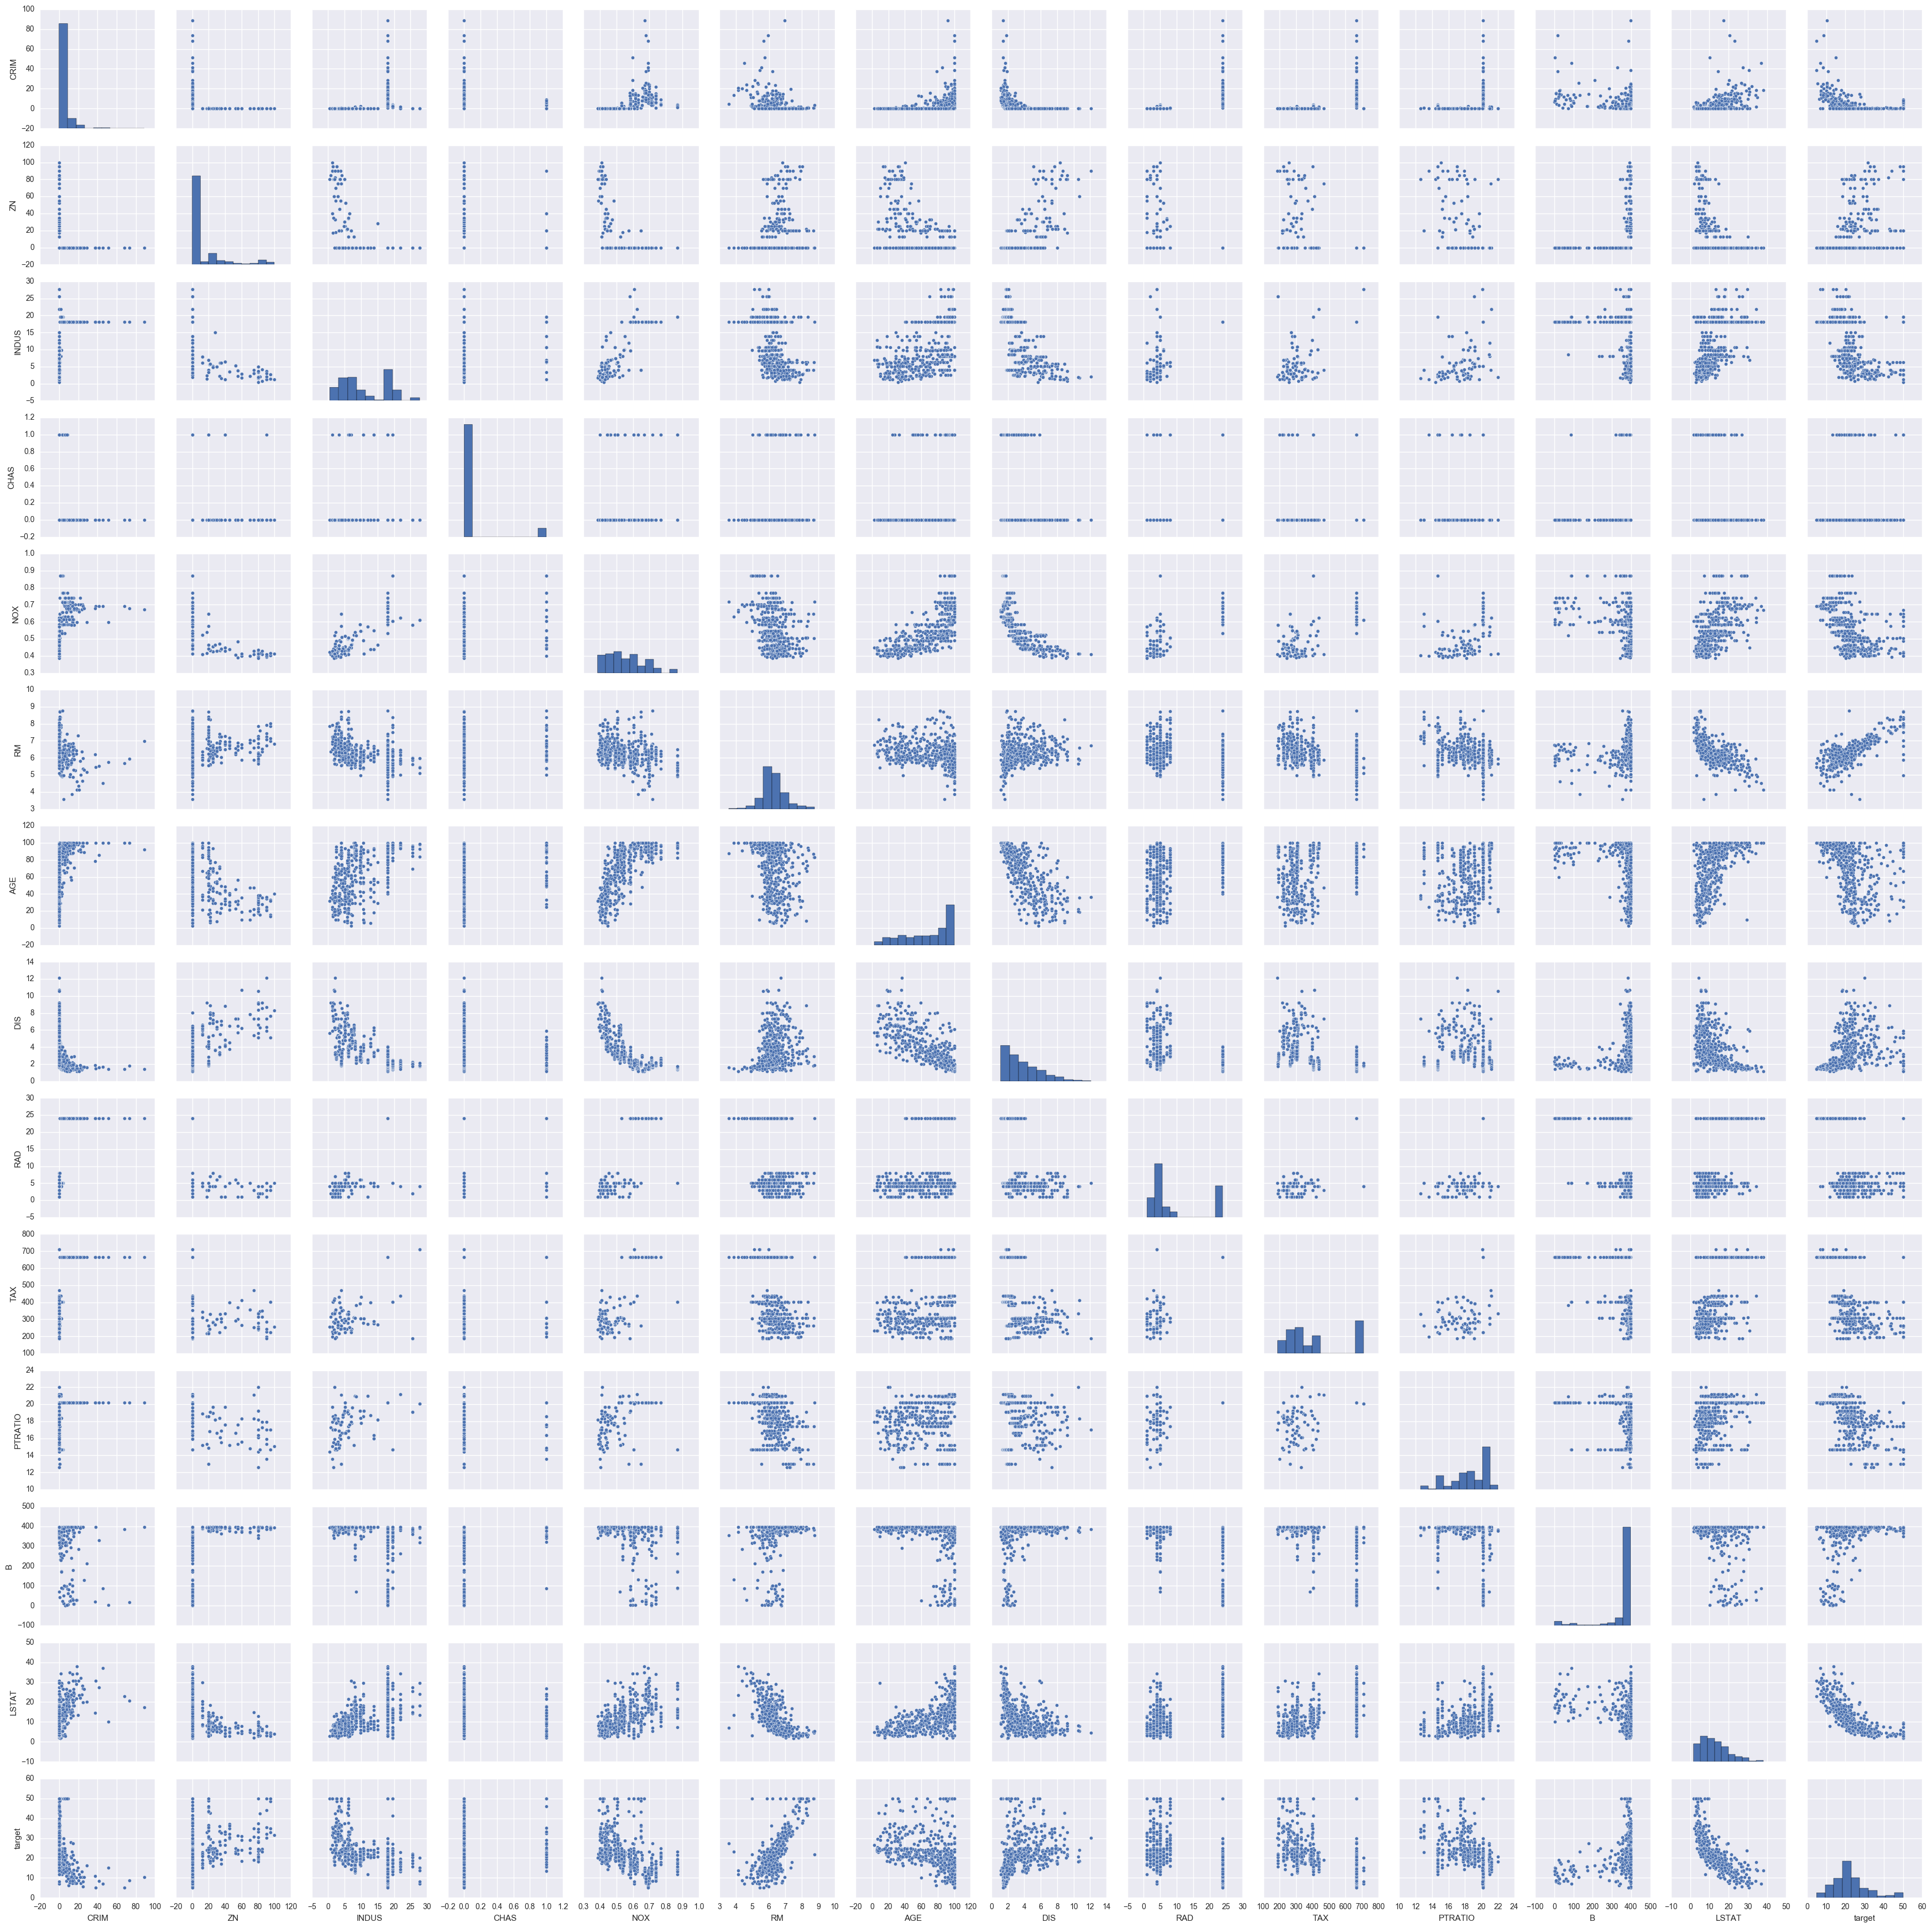

In [2]:
full_data = df
full_data['target'] = y

sns.pairplot(full_data)
plt.show()

Let's lift some code from GitHub Gist to plot a correlation heat map.

[Ryan's Heatmap Cheat Sheet](https://gist.github.com/rddunlap23/02d4014907ffaf9cbdf49f4004f82ba6)

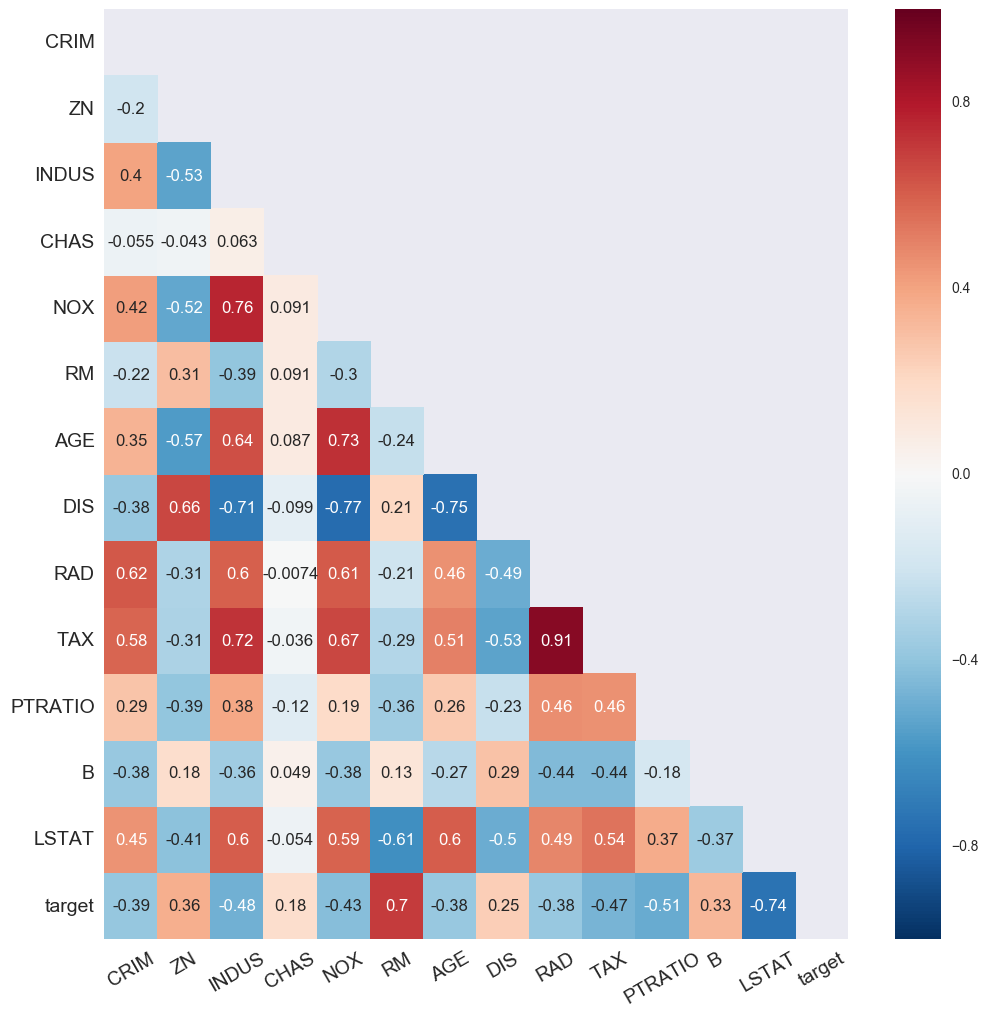

In [3]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
    
correlation_heat_map(df)

RM looks like it has quite a bit of signal in it. Let's build a model using just RM to start. 

In [4]:
X = df[['RM']]
X.head()

,RM
0,6.575
1,6.421
2,7.185
3,6.998
4,7.147


Scikit-learn has a nice function to split a dataset for testing and training called `train_test_split`. The `test_size` keyword argument indicates the proportion of the data that should be held over for testing.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(354, 1) (354,)
(152, 1) (152,)


Now we fit a model on the training data and test on the testing data.

Score: 0.461768870719


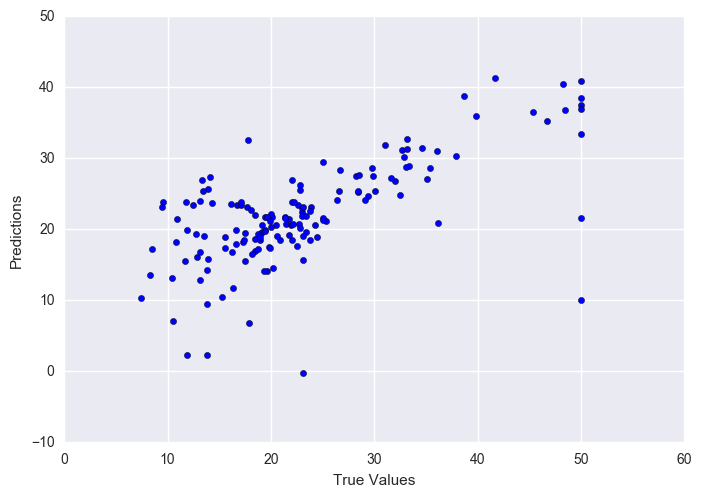

In [8]:
lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print "Score:", model.score(X_test, y_test)     

Note that we could always split the data up manually. Here's an example for [this dataset](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py) of a manual splitting.

Now let's try out k-fold cross-validation. Again scikit-learn provides useful functions to do the heavy lifting. The function `cross_val_predict` returns the predicted values for each data point when it's in the testing slice.

Cross-validated scores: [ 0.68437127  0.20579461 -0.74116176]
Cross-Predicted Accuracy: 0.255802990535


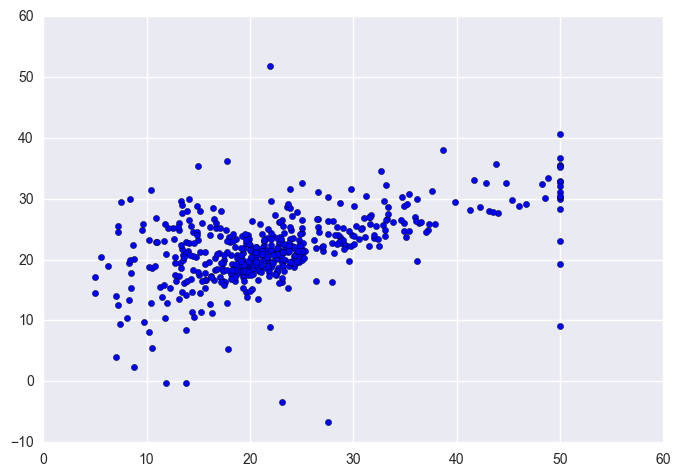

In [11]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 6-fold cross validation
scores = cross_val_score(model, X, y, cv=3)
print "Cross-validated scores:", scores

# Make cross validated predictions
predictions = cross_val_predict(model, X, y, cv=3)
plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)

print "Cross-Predicted Accuracy:", accuracy

# Guided Practice

Use what you've learned to train and test models on the Boston housing data set. If you need a few hints take a look at [this example](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html) but try your best to make it happen first. Complete the following tasks:
* Fit a linear model to the Boston Housing data using all the available variables. Perform test training splits of 50:50, 70:30, and 90:10, comparing the scores on test data.
* For the same setup, perform a $k$-fold cross validation with $k=5$ slices (with cross-validated predictions)

In [12]:
from sklearn import datasets
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same dataset. This could be comparisons of two linear models, or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model that you like. 

### Here's what we will be doing:

* Fix a testing/training split of the data
* Train each of your models on the training data
* Evaluate each of the models on the test data
* Rank the models by how well they score on the testing data set.

**Then try K-Folds**

* Try a few different splits of the data for the same models.
* Perform a k-fold cross validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Think about how you might implement a function to make some of this work easily repeatable**

### 1. Clean up any data
Load the Boston housing data.  Fix any problems, if applicable.

## Using Sklearn Linear Regression

### 2. Select 3-4 variables with your dataset to perform a 50/50 test train split on
Score and plot your predictions.

### 3. Try 70/30 and 90/10
Score and plot.  How do your metrics change?

### 4. Try K-Folds between 5-10 for your regression.

What seems optimal? How do your scores change? What the variance like? Try different folds to get a sense of how this impacts your score.

Folds = 10
Cross-validated scores: [ 0.73334917  0.47229799 -1.01097697  0.64126348  0.54709821  0.73610181
  0.37761817 -0.13026905 -0.78372253  0.41861839]
Cross-Predicted Accuracy: 0.590177393332


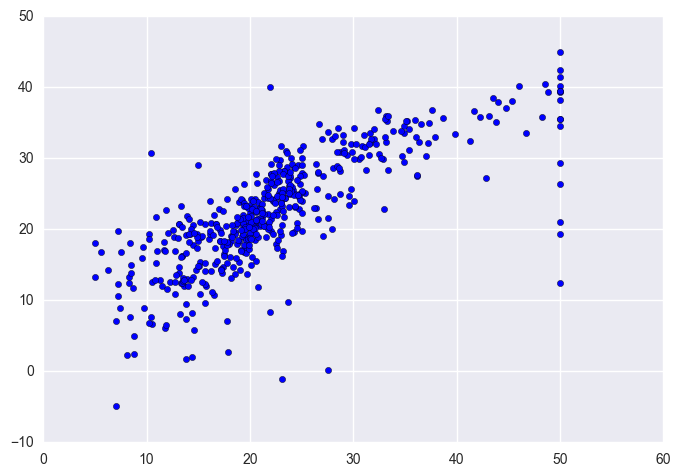

In [24]:
from sklearn.pipeline import make_pipeline

from sklearn.cross_validation import cross_val_score, cross_val_predict
#from sklearn.model_selection import KFold
from sklearn import metrics

# Load the Boston Housing dataset
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)

#Preprocess
X = df     #Predictor
y = boston.target   #Target

#Define Model
lr = linear_model.LinearRegression()

#Define # of Folds
folds = 10
print 'Folds =', folds 

# Perform 6-fold cross validation
scores = cross_val_score(model, X, y, cv=folds)
print "Cross-validated scores:", scores

# Make cross validated predictions
predictions = cross_val_predict(model, X, y, cv=folds)
plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)

print "Cross-Predicted Accuracy:", accuracy